# <a id="top"></a>Autoencoding Edward Hopper:<br>Using deep learning to recommend art

[Larry Finer](mailto:lfiner@gmail.com)  
March 2019

The goal of this project was to build a model that would take an image of an artwork and compare it visually to a corpus of more than 100,000 artworks from museums and other sources in order to find works that are similar visually. The main steps in the project were:

1. Download artwork images and metadata from multiple sites
2. Combine metadata into a single pandas dataframe  
3. **Develop a convolutional neural network autoencoder model that adequately reproduces the images** (this file)
4. Extract the narrowest encoded layer and use it to encode the entire corpus as well as a test image; then compare the test image to the entire corpus using a cosine distance measure to find the nearest images

<hr>  

## 3. Create convolutional neural network autoencoder model

### Sections
[3a. Imports and setup](#3a)  
[3b. Define autoencoder model](#3b)  
[3c. Use ImageDataGenerator to prepare images for model](#3c)  
[3d. Train the model](#3d)  
[3e. Save the autoencoder and the feature extractor](#3e)

### <a id="3a"></a>3a. Imports and setup

In [3]:
import datetime
import numpy as np
import pandas as pd
import os
import cv2
import pickle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [4]:
# Set some parameters for use when tweaking CNN model for best performance.
image_dimension = 200
epochs = 20
batch_size = 20

3. Run model
4. Save database? of encoded features for all images
5. Build web front end to take a URL or uploaded image
6. Build Flask app to:
    1. Run the new image through my model
    2. Find the x images in my database that are closest (cosine similarity? Manhattan distance?) 
    3. Display them

### <a id="3b"></a>3b. Define autoencoder model

In [5]:
# Input layer
input_img = Input(shape=(image_dimension, image_dimension, 3))

# Encoding layers
x = Conv2D(512, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)

# Decoding layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create model instance
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 512)     14336     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 512)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      294976    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 16)        9232      
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 25, 25, 16)        0         
__________

### <a id="3c"></a>3c. Use ImageDataGenerator to prepare images for model

In [9]:
# Establish directories for image files.
base_directory = '../data/autoencoder/'
training_directory = os.path.join(base_directory, 'train/')
validation_directory = os.path.join(base_directory, 'validate/')
test_directory = os.path.join(base_directory, 'test/')

In [11]:
# Sample files that will be used to train model.
# Draw from folder that contains all images.
sample_size = 10000
allimage_directory = '../data/images/allimages/'
total_image_count = len([name for name in os.listdir(allimage_directory)])
all_image_names = os.listdir(allimage_directory)
sample_indices = np.random.randint(0, total_image_count, size=sample_size)
training_sample_indices = sample_indices[:int(sample_size*.8)]
validation_sample_indices = sample_indices[int(sample_size*.8):]

In [13]:
# Copy images into training and validation folders
from shutil import copy2
for training_sample_index in training_sample_indices:
    copy2(allimage_directory + all_image_names[training_sample_index], training_directory + all_image_names[training_sample_index])
for validation_sample_index in validation_sample_indices:
    copy2(allimage_directory + all_image_names[validation_sample_index], validation_directory + all_image_names[validation_sample_index])

In [17]:
# Create generators to process the images.
# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1./255)

training_generator = datagen.flow_from_directory(
        training_directory,
        target_size=(image_dimension, image_dimension),
        batch_size=batch_size,
        # Since this is unsupervised there are no classes
        class_mode='input')

validation_generator = datagen.flow_from_directory(
        validation_directory,
        target_size=(image_dimension, image_dimension),
        batch_size=batch_size,
        # Since this is unsupervised there are no classes
        class_mode='input')

Found 13723 images belonging to 1 classes.
Found 2957 images belonging to 1 classes.


### <a id="3d"></a>3d. Train the model 

In [21]:
# Set up early stopping if additional epochs don't change loss.
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [18]:
# Get number of samples for use in calculating number of steps.
training_samples = training_generator.samples
validation_samples = validation_generator.samples

# Calculate number of steps.
training_steps = training_samples / batch_size
validation_steps = validation_samples / batch_size

The next cell is the big one: train the model.

In [1]:
# Train the model.
history = autoencoder.fit_generator(
      training_generator,
      steps_per_epoch=training_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[early_stopping])

### <a id="3e"></a>3e. Save the autoencoder model and the feature extractor (i.e., the model through the encoded layer)

In [16]:
# Save the autoencoder model.
autoencoder.save('../data/autoencoder/models/autoencoder.h5')

In [18]:
# Create and save the feature extractor model.
feature_extractor = \
    Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded_layer').output)
feature_extractor.save('../data/autoencoder/models/feature_extractor.h5')

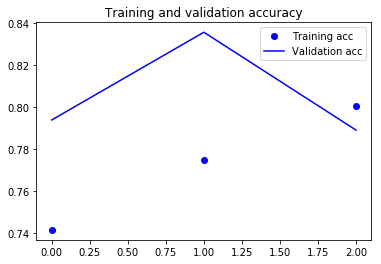

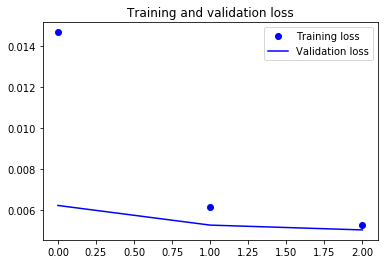

In [19]:
# Look at accuracy and loss for training and validation sets
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()